# What drives the price of a car?

<!--![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

----
The goal of this project is to determine the attributes which correspond in used cars to
- A more expensive price tag.
- More consumer value.

The first goal seems relatively straightforward -- our goal is to determine which features in a used car maximize the resultant car sale. On a sale-by-sale basis, what attributes will ultimately maximize return on that vehicle.

The second goal is more nebulous -- it asks, what features make a consumer more likely to purchase a car in the first place? What customer base provides the largest volume of revenue? 

----

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [132]:
import pandas as pd
data = pd.read_csv('./data/vehicles.csv')
data.info()

# This dataset is quite large, however there are a substantial number of NaNs, as is evident by the verying number of non-nulls. 
# Some of the columns' non-null counts represent just half of the total dataset length. 
# Crucial to maintaining the diversity of this dataset will be handling the NaN values in a way which doesn't exclude them entirely. 
# Luckily, many of these are objects, and can be one-hot encoded.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [133]:
# The first modification we can make is to drop the 'id' and 'vin'
del data['id']
del data['VIN']

# I make the call to drop the 'region' feature-- 
# the region strings vary substantially from counties to states,
# there are many labelled regions which are subregions of other named regions, 
# and the 'state' feature still characterizes region on a broader scale.
del data['region']

# There are a LOT of models encoded in the dataset. We can remove them as they are not generalized enough
del data['model']

# We cannot drop ALL of the NaNs in this dataset as it would reduce its size to a QUARTER

# Let's remove the NaNs for the numeric columns only -- odometer and year
data = data.loc[~data['odometer'].isna() & ~data['year'].isna()]

# The remaining NaNs we can encode as unknown instead
data.fillna('Unk', inplace=True)


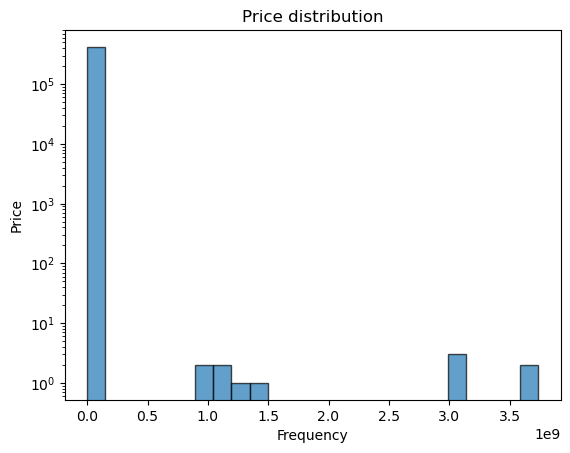

In [134]:
import plotly.express as px

# This is an interesting facet -- the dependent price variable seems to be very inconsistent.
# There are large outliers in the extremes of the distribution.

# This ends up being an effective way to remove fake information in the dataset.
# e.g. some entries with price "1234567", etc.

plt.hist(data.price, bins=25, alpha = 0.7, edgecolor='black')
plt.title('Price distribution')
plt.xlabel('Frequency')
plt.ylabel('Price')
plt.yscale('log')

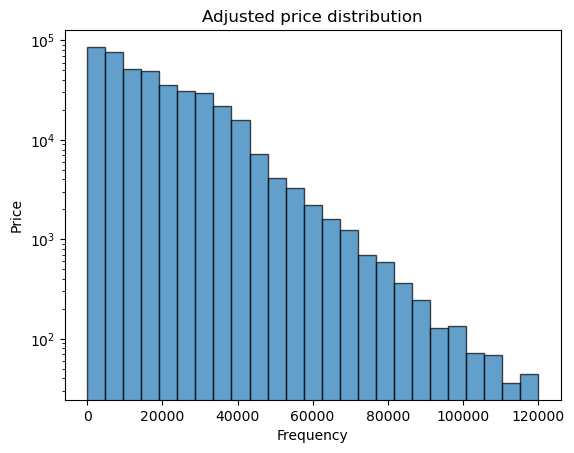

In [135]:
# In this case, I cut the dataset to include only prices which are 
# below the 99.9th percentile, to avoid skewing the dataset.

p99 = data['price'].quantile(.999)

# And now this distribution appears much more reasonable.
data = data.query('price < @p99')

plt.hist(data.price, bins=25, alpha = 0.7, edgecolor='black')
plt.title('Adjusted price distribution')
plt.xlabel('Frequency')
plt.ylabel('Price')
plt.yscale('log')

In [9]:
from sklearn.model_selection import train_test_split

# Let's now prepare our training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price'], train_size = 0.8, random_state = 42)
# I include the random state so that the cluster labels are consistent. 
# I could use dbscan to regularize this, but I found KMeans to work better.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector

import numpy as np

Text(0, 0.5, 'Inertia')

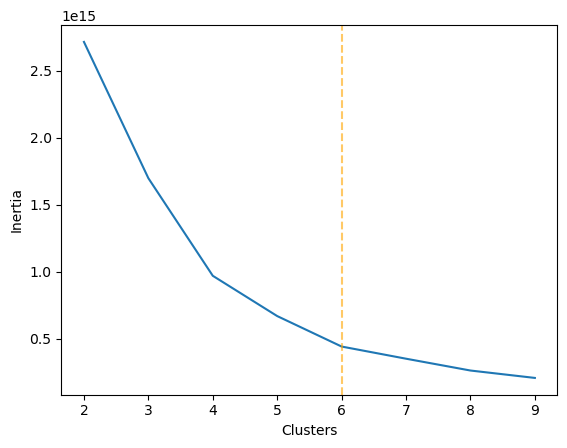

In [15]:
# Let's first conduct some clustering to better understand our customer segments

# Let's one-hot encode all of our 
tfe = make_column_transformer(
    (OneHotEncoder(), ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'condition', 'cylinders']),
    remainder = 'passthrough'
)

# inertias = []
# for clusters in range(2,10):
#     km = Pipeline( [('tfe', tfe), ('km', KMeans(n_clusters = clusters))] )
#     km.fit(X_train, y_train)
#     inertias.append(km['km'].inertia_)

plt.plot(range(2,10), inertias)
plt.axvline(6, linestyle='--', alpha = 0.6, color='orange')
#plt.yscale('log')
plt.xlabel('Clusters')
plt.ylabel('Inertia')

In [123]:
# We can estimate the inflection point of the inertia at around 6 clusters.
km = Pipeline( [('tfe', tfe), ('km', KMeans(n_clusters = 6, random_state = 42))] )
km.fit(X_train, y_train)

X_train['Cluster'] = km.predict(X_train)
X_test['Cluster'] = km.predict(X_test)
data['Cluster'] = km.predict(data.drop('price', axis=1))


# The size of each of these clusters is informative for how much price volume occurs in each of the segments.
# Let's perform some limited work here and continue the rest in the Evaluation section.

cluster_results = pd.DataFrame(columns = ['Cluster', 'Total money spent', 'Number of purchases', 'Avg Price per purchase'])
for i in range(0,6): # For each cluster
    filter = np.where(X_train['Cluster'] == i) # Filter by members of that cluster
    cluster = X_train.iloc[filter]
    cluster_results.loc[cluster_results.shape[0]] = [i, y_train.iloc[filter].sum(), cluster.shape[0], # Calculate total money & purchases
    y_train.iloc[filter].sum()/cluster.shape[0]] # Calculate avg price per purchase

cluster_results.loc[cluster_results.shape[0]] = ['All', y_train.sum(), X_train.shape[0], y_train.sum()/X_train.shape[0]] # This just provides the 'All' values
cluster_results = cluster_results.set_index('Cluster')
cluster_results

,Total money spent,Number of purchases,Avg Price per purchase
Cluster,,,
0.0,1.783175e+09,135185.0,13190.627540
1.0,4.751120e+05,117.0,4060.786325
2.0,3.531408e+09,142565.0,24770.510441
3.0,2.409100e+05,37.0,6511.081081
4.0,5.239896e+08,58021.0,9031.032798
5.0,1.150772e+07,809.0,14224.627936
All,5.850796e+09,336734.0,17375.127267


----
The average used car price comes out to roughly 17k, for a total market volume of 5.8 billion.

The most populous clusters are 0, 2 and 4 corresponding to the vast majority of sales. The other clusters encapsulate smaller volumes and lower prices, generally.

In order to capitalize on the most amount of revenue, we want to look at the differences between these top 3 clusters.

- Cluster 0 has an average sale price of 13k and represents the second-largest volume.
- Cluster 4 has an average sale price of 9k and represents the third-largest volume.
- Cluster 2 has the largest avg. sale price of 25k and represents the largest volume of consumers.

For the sake of simplifying this analysis, let's focus mainly on Clusters 0 and 2, as they represent the greatest number of customers.

----
For each of these clusters, we want to determine two things:
- What characteristics are members of this cluster <i>looking</i> for when purchasing a used car?
- What characteristics <i>boost the price</i> when purchased by a member of these clusters?

In [18]:
cluster_transformer = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'condition', 'cylinders', 'Cluster']),
        remainder = 'passthrough'
    )

# Find correlation matrix; select just the corresponding cluster columns
correlation_matrix = pd.DataFrame( cluster_transformer.fit_transform(X_train) , 
columns= cluster_transformer.get_feature_names_out()).corr()[['onehotencoder__Cluster_0','onehotencoder__Cluster_2']]#[['onehotencoder__Cluster_%s'%i for i in range(0,6)]]

correlation_matrix

,onehotencoder__Cluster_0,onehotencoder__Cluster_2
onehotencoder__manufacturer_Unk,-0.030092,0.006965
onehotencoder__manufacturer_acura,-0.023001,0.033876
onehotencoder__manufacturer_alfa-romeo,-0.037389,0.051098
onehotencoder__manufacturer_aston-martin,-0.006312,0.008994
onehotencoder__manufacturer_audi,-0.013901,0.048408
...,...,...
onehotencoder__Cluster_3,-0.008585,-0.008983
onehotencoder__Cluster_4,-0.373670,-0.390958
onehotencoder__Cluster_5,-0.040191,-0.042050
remainder__year,-0.096707,0.277961


----
Members of Cluster 0 (13k avg. sale price)

Tend to value (in order of magnitude of correlation)
- Transmission: automatic
- Condition: excellent
- Fuel: gas
- Year being higher

Tend not to value
- Transmission: other
- Condition: good
- Fuel: other
- Cylinders: 4
----
Members of Cluster 2 (25k avg. sale price)

Value
- Transmission: other
- Year being higher
- Condition: good
- Fuel: other

Don't value
- Transmission: automatic
- Odometer being higher
- Condition: excellent
- Size: full-size
- Fuel: gas

----

### Customer segment behaviors

This answers our first question for what buyers in each cluster tend to value. Cluster 0 appears to trend more towards a casual consumer, whereas cluster 2 may include consumers whose preferences may be business oriented (i.e. fuel and transmission: other).

Both groups, however, value a newer car (year = higher) in good or excellent condition.

----
### Maximizing vehicle price

Starting with Cluster 0 and then continuing to Cluster 2, let's try to maximize the price that they are willing to pay.

Both clusers are most characterized by the transmission, condition, fuel and year variables. We'll include odometer because it is already numerical.

Let's one-hot encode the transmission, condition and fuel variables and try to fit these trends with a multilinear regression.

---

In [77]:
top_variables = ['fuel', 'transmission', 'condition', 'year', 'odometer']

# This model first one-hot encodes the non-numerical variables.
# It then creates polynomial features up to n.
# Those features are normalized.
# The data is then fit by a multilinear Ridge regression with a given alpha.
model = Pipeline([
    ('tfe', make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        ['fuel', 'transmission', 'condition']),
        remainder = 'passthrough'
    )),
    ('pf', PolynomialFeatures(degree=2)),
    ('sc', StandardScaler()),
    ('lr', Ridge())
])

# We'll explore a parameter space of up to a polynomial order 2.
# I originally explored up to 5 and found the scoring to be poorer or negligible.
# Minimizing the polynomial order decreases search time tremendously.

# I also originally explored alpha from 1e-4 to 1e4
# However I've since found the interval 1e-4 to 1e3 to best capture the fit.
parameter_space = {'lr__alpha':np.logspace(-4,3, 8), 'pf__degree': np.arange(1, 3)}

# I use cv=2 to provide the GridSearch in order to tune the hyperparameters, 
# but recall that we still have X_test to later validate the model results.
# We will minimize on the negative mean squared error.
search = GridSearchCV(estimator = model, param_grid = parameter_space, cv=2, verbose=3, scoring='neg_mean_squared_error')
#search

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Pipeline(steps=[('tfe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['fuel', 'transmission',
                                                   'condition'])])),
                ('pf', PolynomialFeatures()), ('sc', StandardScaler()),
                ('lr', Ridge(alpha=0.1))])

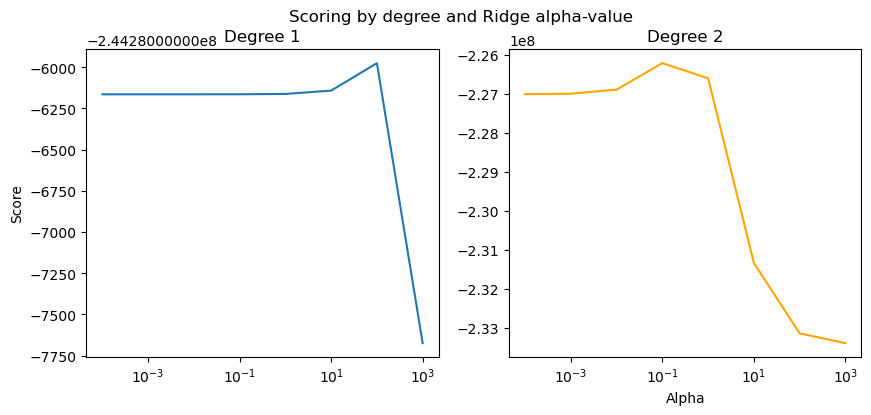

In [87]:
# Just a helper function to unpack scores and plot.
def plot_scores(scores):
    deg_1_scores = scores[::2] # Odd-indexed scores
    deg_2_scores = scores[1::2] # Even-indexed scores

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(parameter_space['lr__alpha'], deg_1_scores, label ='degree 1')
    ax[1].plot(parameter_space['lr__alpha'], deg_2_scores, color='orange', label ='degree 2')
    fig.suptitle('Scoring by degree and Ridge alpha-value')
    ax[0].set_title('Degree 1')
    ax[1].set_title('Degree 2')
    ax[0].set_ylabel('Score')
    ax[1].set_xlabel('Alpha')
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')
    fig.show()

# Filter the cluster 0 members
cluster_0_filter = np.where(X_train['Cluster'] == 0)

# Fit the model
#search.fit(X_train.iloc[cluster_0_filter][top_variables], y_train.iloc[cluster_0_filter])

# Plot
plot_scores(search.cv_results_['mean_test_score'])

# Save the best model
best_cluster_0_model = search.best_estimator_
best_cluster_0_model

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Pipeline(steps=[('tfe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['fuel', 'transmission',
                                                   'condition'])])),
                ('pf', PolynomialFeatures()), ('sc', StandardScaler()),
                ('lr', Ridge(alpha=0.1))])

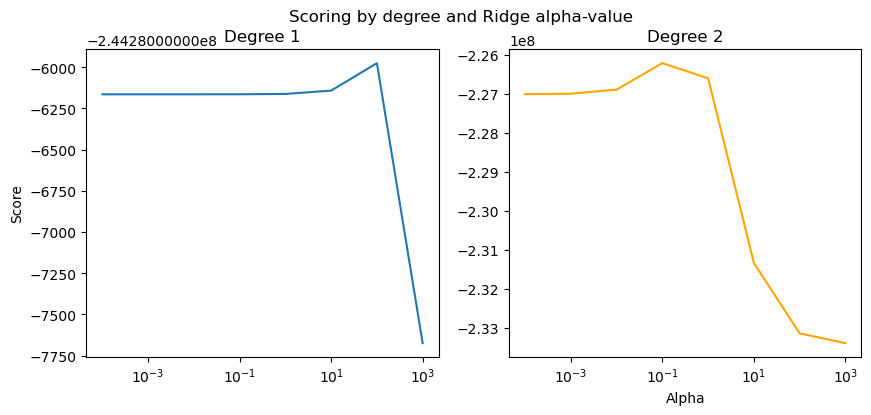

In [85]:
# Filter the cluster 2 members
cluster_2_filter = np.where(X_train['Cluster'] == 2)

# Fit the model
#search.fit(X_train.iloc[cluster_2_filter][top_variables], y_train.iloc[cluster_2_filter])

# Plot
plot_scores(search.cv_results_['mean_test_score'])

# Save the best model
best_cluster_2_model = search.best_estimator_
best_cluster_2_model

----

We can clearly see that the cluster 0 and 2 models both perform better with a polynomial feature order of 2 and an alpha of 1e-1.

----

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [101]:
from sklearn.metrics import mean_squared_error

def compare_MSEs(cluster, model):
    train_filter = np.where(X_train['Cluster']==cluster)
    test_filter = np.where(X_test['Cluster']==cluster)
    print('Training MSE: %.f'%mean_squared_error(y_train.iloc[train_filter], model.predict(X_train.iloc[train_filter][top_variables])))
    print('Test MSE: %.f'%mean_squared_error(y_test.iloc[test_filter], model.predict(X_test.iloc[test_filter][top_variables])))

def compare_scores(cluster, model):
    train_filter = np.where(X_train['Cluster']==cluster)
    test_filter = np.where(X_test['Cluster']==cluster)
    print('Training Score: %.2f'%model.score(X_train.iloc[train_filter][top_variables], y_train.iloc[train_filter]))
    print('Test Score: %.2f'%model.score(X_test.iloc[test_filter][top_variables], y_test.iloc[test_filter]))


print('For Cluster 0 model: ')
compare_MSEs(0, best_cluster_0_model)
compare_scores(0, best_cluster_0_model)

print('\nFor Cluster 2 model: ')
compare_MSEs(2, best_cluster_2_model)
compare_scores(2, best_cluster_2_model)

For Cluster 0 model: 
Training MSE: 252425827
Test MSE: 254384402
Training Score: -1.06
Test Score: -1.12

For Cluster 2 model: 
Training MSE: 223787891
Test MSE: 218830499
Training Score: 0.18
Test Score: 0.19


----
### Though the MSEs for training & testing are largely consistent for each of the cluster models, the training scores are quite poor. 
I would not feel comfortable deploying this model as a predictive model to inform business decisions.

I spent a substantial amount of time trying to tune the model, but to little avail. I tried using LASSO and a normal LinearRegression as well. The Ridge model edged those out by a thin margin. If I were to minimize on score instead of negative MSE, the model comes out better -- but only to a score of about 0.4; therefore, I chose to keep with what the course has taught us (using negative MSE) as the performance wasn't much more instructive. I also used Sequential Feature Selection and Feature Permutation Importance, but I came up with identical results to the simple correlations that the clustering algorithm produces.

----
On that note, let's let the conclusions from the clustering algorithm do most of the talking.

----

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

---

### To whom it may concern,

The following conclusions are made using a dataset of nearly half a million car sales. The dataset is initially cleaned its outliers pruned.

The average used car price comes out to roughly 17k, for a total market volume of 5.8 billion.

#### General results: low- and high-end markets

Following our analysis, I have concluded that the used car market is composed of roughly two large groups which encapsulate nearly all revenue in used car sales: low-end and the high-end vehicle markets. The primary means by which this analysis was conducted was by performing a clustering analysis -- essentially 'clustering' members into each of those groups as neatly as possible.

In the following data snippet, Cluster 0 corresponds to the low-end market and Cluster 2 corresponds to the high-end market.

In [127]:
cluster_results.loc[[0,2,'All']]

,Total money spent,Number of purchases,Avg Price per purchase
Cluster,,,
0,1.783175e+09,135185.0,13190.627540
2,3.531408e+09,142565.0,24770.510441
All,5.850796e+09,336734.0,17375.127267


We find that the low-end market has a total value of 1.78 billion, with an average car price of roughly 13k, and encapsulates about 40% of all car sales.

The higher-end market has a total value of 3.53 billion and an average car price of 25k, encapsulating 42% of all car sales.

While both cover a relatively similar number of purchases, the total market value of the higher-end market is twice as great as that of the lower-end market.

Text(0, 0.5, 'Price')

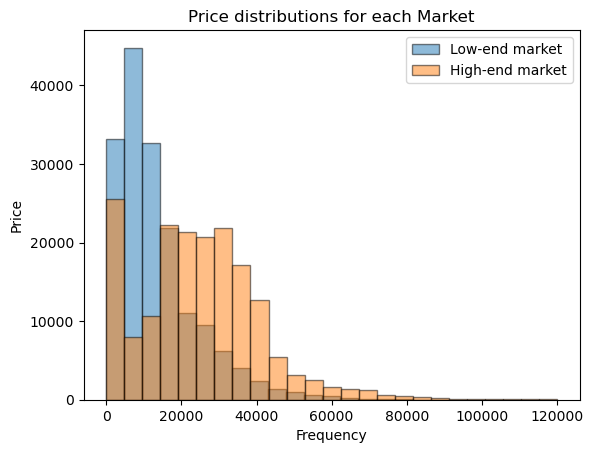

In [131]:
cluster_0 = data.query('Cluster == 0')
cluster_2 = data.query('Cluster == 2')

plt.hist(cluster_0.price, bins=25, alpha = 0.5, edgecolor='black', label = 'Low-end market')
plt.hist(cluster_2.price, bins=25, alpha = 0.5, edgecolor='black', label = 'High-end market')
plt.title('Price distributions for each Market')
plt.xlabel('Frequency')
plt.legend()
plt.ylabel('Price')

We can clearly see that the high-end market has a broader distribution of prices, which suggests that the prices themselves have more wiggle-room. The vast majority of sales are closed in the range of 17 - 40k. There is some issues with outliers in the low-end of this cluster, however those are vehicles which were likely transferred for free, such as between family members.

The lower-end market has much less variance and is sharply peaked around its average value. We can expect much less wiggle-room when it comes to price in this segment.

#### Characteristics of the low-end market

We can use simple correlation analysis to provide characteristics in a used vehicle that different segments value more or less.

In the lower-end market, customers: 

Tend to value (in order of importance)
- Transmission: automatic
- Condition: excellent
- Fuel: gas
- Year being higher (car is newer)

Tend not to value
- Transmission: other
- Condition: good
- Fuel: other
- Cylinders: 4

As such, an ideal vehicle in the low-end market will be a gas-powered, automatic transmission in good condition. They tend to value a newer car. Notably, the number of miles on the car has less significance.


#### Characteristics of the high-end market

Similarly, for the higher-end market, customers:

Tend to value
- Transmission: other
- Year being higher
- Condition: good
- Fuel: other

Tend not to value
- Transmission: automatic
- Odometer being higher
- Condition: excellent
- Size: full-size
- Fuel: gas

These characteristics are a little more varied, likely because the distribution of the customers is a little broader (see the plot above). As such, some of the purchases in this segment may also be commercial vehicles. As such, the 'ideal' car in the high-end market is a little fuzzier, though it tends not to be a automatic vehicle. That vehicle should have a good condition (though not necessarily 'excellent', though this could be a self-reporting bias) and have a lower number of miles.

#### How to generate better car sales

Choosing which market to operate in will dictate the average sale price and volume of sales to be expected. Both the low-end and high-end markets have a great deal of potential value, however cars which fit the profile of the high-end market tend to capture a larger population and a larger price. You can expect for higher-end vehicles to be sold <i>slightly</i> more consistently, and at a better price. In order to improve car sales, attempt to buy and sell vehicles which fit this profile.

Thanks,
Xavier
